# Machine Learning : Predicting Chord



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean
from statistics import median
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
from chorder import Chord, Dechorder
import os
import math
import numpy as np

from tool_wave import *
from tool_midi import *
from tool_generate import *
from tool_fix import *
from tool_chord import *
from tool_emotion import *

print("Done")

Done


## 1. Data Preparation

EMOPIA dataset contains midi files from 4 emotion categories.

In [3]:
path_Q1 = "./EMOPIA/midis/Q1"
biglistQ1 = ChordPerSet(path_Q1)    # only chord names, in C scale

After we get chord name sequence from the midi dataset, we can turn music chords into NLP.

The problem is now a word2vec CBOW model.

In [4]:
def XandY(song, window):
    X = []
    Y = []
    for i in range(window, len(song)-window):
        x = song[ i-window : i ] + song[ i+1 : i+window+1 ]
        y = song[i]
        X.append(x)
        Y.append(y)
    return X, Y

def Content_Target(biglist, window):
    content = []
    target = []
    for song in biglist:
        X, Y = XandY(song, window)
        content += X
        target += Y
    return content, target

In [5]:
window = 2
content, target = Content_Target(biglistQ1, window)

content = np.array(content)
target = np.array(target)
print(content.shape, content[0])
print(target.shape, target[0])

(15643, 4) ['BbM7' 'BbM7' 'BbM7' 'Dm7']
(15643,) BbM7


In [6]:
vocab =set({})
for song in content:
    vocab.update(song)
print(len(vocab))

word_to_id = {word: i for i, word in enumerate(vocab)}
id_to_word = {i: word for i, word in enumerate(vocab)}

90


In [7]:
mostused = pd.DataFrame(target).value_counts()
mostused[:10]

CM     2483
FM7    1522
GM     1430
Am7    1421
FM     1228
CM7    1180
Am      777
Dm7     770
Em7     621
G7      570
dtype: int64

In [8]:
vocab_size = len(vocab)

batch_size = 128
embed_size = 128
window = 2
context_size = 2 * window

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64  # Number of negative examples to sample.

In [9]:
print(f"Vocabulary Size: {vocab_size}")
print(f"Vocabulary Sample : {list(word_to_id.items())[:4]}")
print(f"Vocabulary Sample : {list(word_to_id.items())[-4:]}")

Vocabulary Size: 90
Vocabulary Sample : [('Gm7', 0), ('Am7', 1), ('G#sus2', 2), ('B', 3)]
Vocabulary Sample : [('B+', 86), ('EbM7', 87), ('Eo', 88), ('Bm7', 89)]


## 2. Model Training

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout
from tensorflow.keras import models, callbacks

In [11]:
# one-hot encoding
features = np.array([[word_to_id[chord] for chord in chord4] for chord4 in content])
features = tf.one_hot(features, depth=vocab_size)
features = features.numpy()
labels = np.array([word_to_id[chord] for chord in target])
labels = tf.one_hot(labels, depth=vocab_size)
labels = labels.numpy()

a, b, c = features.shape[1], features.shape[2], labels.shape[1]

print(type(features), features.shape)
print(type(labels), labels.shape)
print(a, b, c)

<class 'numpy.ndarray'> (15643, 4, 90)
<class 'numpy.ndarray'> (15643, 90)
4 90 90


In [12]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=28)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.2, random_state=28)
print(type(train_features), train_features.shape)
print(type(train_labels), train_labels.shape)

<class 'numpy.ndarray'> (10011, 4, 90)
<class 'numpy.ndarray'> (10011, 90)


In [13]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

model = Sequential([
    Reshape((a*b, ), input_shape=(a, b)),
    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=c, activation='softmax')
])

CB = [
        callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss"),

        callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=5)
]

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_features, train_labels, validation_data=(val_features, val_labels), 
                    batch_size=256, epochs=50, callbacks=CB, verbose=1)

Epoch 1/50
40/40 [==============================] - 0s 5ms/step - loss: 3.8114 - accuracy: 0.3440 - val_loss: 2.8285 - val_accuracy: 0.4579
Epoch 2/50
40/40 [==============================] - 0s 3ms/step - loss: 2.1918 - accuracy: 0.5129 - val_loss: 1.8262 - val_accuracy: 0.5278
Epoch 3/50
40/40 [==============================] - 0s 3ms/step - loss: 1.5963 - accuracy: 0.5739 - val_loss: 1.4828 - val_accuracy: 0.5625
Epoch 4/50
40/40 [==============================] - 0s 3ms/step - loss: 1.3210 - accuracy: 0.6246 - val_loss: 1.2917 - val_accuracy: 0.6161
Epoch 5/50
40/40 [==============================] - 0s 3ms/step - loss: 1.1551 - accuracy: 0.6655 - val_loss: 1.1741 - val_accuracy: 0.6496
Epoch 6/50
40/40 [==============================] - 0s 3ms/step - loss: 1.0470 - accuracy: 0.6873 - val_loss: 1.0948 - val_accuracy: 0.6724
Epoch 7/50
40/40 [==============================] - 0s 3ms/step - loss: 0.9697 - accuracy: 0.7106 - val_loss: 1.0387 - val_accuracy: 0.6852
Epoch 8/50
40/40 [==

## 3. Model Evaluation

In [14]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

98/98 [==============================] - 0s 628us/step - loss: 0.8318 - accuracy: 0.7549
Test accuracy: 0.7548737525939941


<AxesSubplot:>

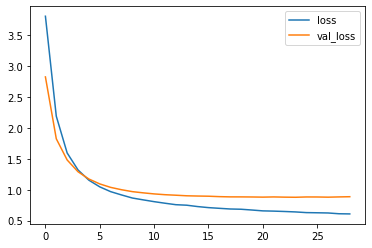

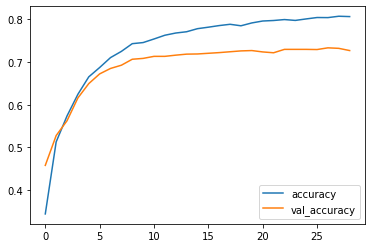

In [15]:
modelFinal = models.load_model("fine_tuning.keras")
df=pd.DataFrame(history.history)
dfloss=df[['loss','val_loss']]
dfloss.plot()
dfAC=df[['accuracy','val_accuracy']]
dfAC.plot()

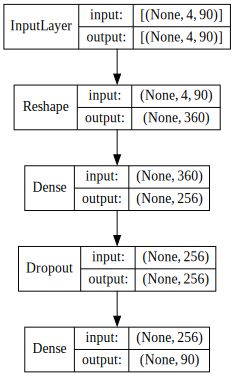

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(modelFinal, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=70).create(prog='dot', format='svg'))

In [17]:
modelFinal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 360)               0         
                                                                 
 dense (Dense)               (None, 256)               92416     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 90)                23130     
                                                                 
Total params: 115,546
Trainable params: 115,546
Non-trainable params: 0
_________________________________________________________________
